In [1]:
import sys
sys.path.append("../../library/")
sys.path.append("../lib/")
import numpy as np
import matplotlib.pyplot as plt
import read_data as rd
from sub_plot import *
from defaultPlot import *
from dataProcess import *
from stringFormat import *


In [2]:
time = {}
points = {}
#* ---------------------------------------------------------
orderParameter = {}
meanClusterSize = {}
orderParameterVariance = {}
secondMoment = {}
#* ---------------------------------------------------------
netOrderParameter = {}
netSecondMoment={}
netOrderParameterVariance = {}

In [8]:
for networkSize in networkSizeList:
# for networkSize in [10000]:
    time[networkSize] = np.arange(0.0, 1.0, 1/networkSize)
    # for acceptanceThreshold in acceptanceThresholdList:
    for acceptanceThreshold in [0.5]:
        current = networkSize, acceptanceThreshold
        points[current] = rd.readPoints(networkSize, acceptanceThreshold)
        #* -------------------------------------------------------
        orderParameter[current] = rd.read("orderParameter", networkSize, acceptanceThreshold)
        meanClusterSize[current] = rd.read("meanClusterSize", networkSize, acceptanceThreshold)
        secondMoment[current] = rd.read("secondMoment", networkSize, acceptanceThreshold)
        orderParameterVariance[current] = networkSize * (secondMoment[current] - orderParameter[current] ** 2.0)
        #* ---------------------------------------------------------
        netOrderParameter[current] = {}
        netSecondMoment[current] = {}
        netOrderParameterVariance[current] = {}
        for accumulate in ["78"]:
            for state in ["sub", "super"]:
                netOrderParameter[current][accumulate + state] = rd.read("netOrderParameter", networkSize, acceptanceThreshold, accumulate + state)
                netSecondMoment[current][accumulate + state] = rd.read("netSecondMoment", networkSize, acceptanceThreshold, accumulate + state)
                if np.array_equal(netSecondMoment[current][accumulate + state][0], netOrderParameter[current][accumulate + state][0]):
                    netOrderParameterVariance[current][accumulate + state] = netSecondMoment[current][accumulate + state][0],  networkSize * (netSecondMoment[current][accumulate + state][1] - netOrderParameter[current][accumulate + state][1] ** 2.0)
                else:
                    print("Different net ensemble at N{:.1e},G{:.1f}".format(*current))
        #* ---------------------------------------------------------

In [4]:
acceptanceThreshold = 0.5

# Mean Cluster Size

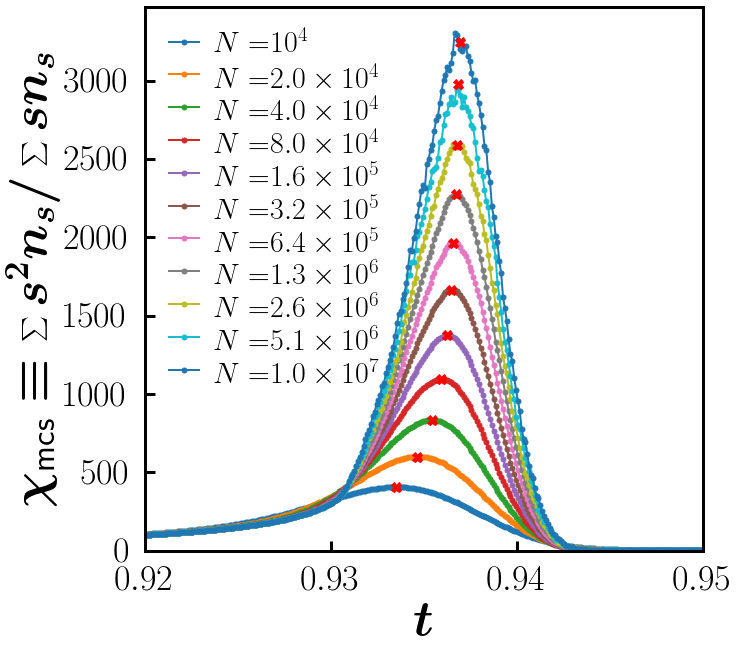

In [10]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotMCS(networkSize, plot_tc):
    current = networkSize, acceptanceThreshold
    t, mcs = avgLinBin(time[networkSize], meanClusterSize[current])
    ax.plot(t, mcs, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2, markersize=5)
    t_mcs_c = points[current]["t_mcs_c"]
    ax.plot(t_mcs_c, meanClusterSize[current][int(networkSize * t_mcs_c)], 'rX', markersize=10)
    if plot_tc:
        ax.plot([points[current]["t_c"],points[current]["t_c"]], [0, networkSize/10], 'g-', linewidth=2, label=latex_string("t_c({:.1e})".format(networkSize)))

for networkSize in networkSizeList:
    plotMCS(networkSize, False)

ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("\chi_\\text{mcs} \equiv \sum s^2 n_s / \sum sn_s"))
ax.set_xlim(chi_plotRange[acceptanceThreshold])
ax.set_ylim(bottom = 0)
ax.legend(loc="best", fontsize=30)

fig.show()

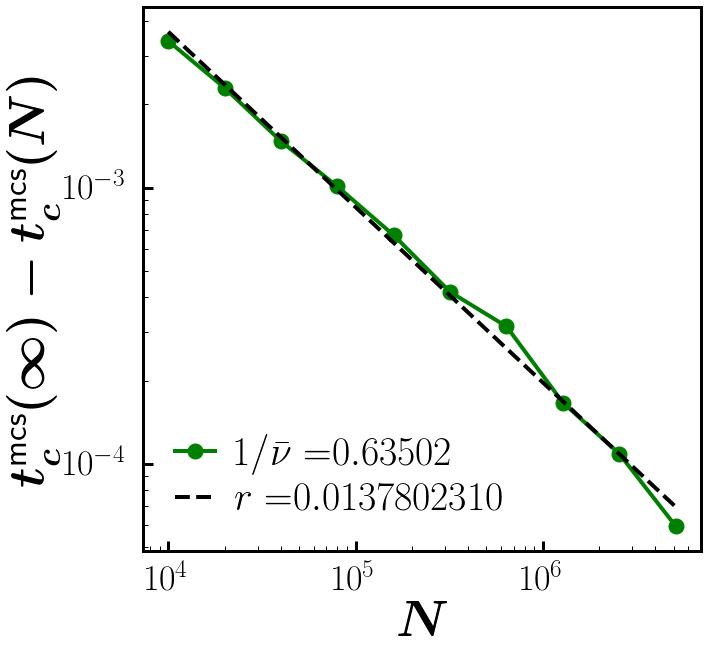

In [105]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_rasterized(True)

NList = [10000, 20000, 40000, 80000, 160000, 320000, 640000, 1280000, 2560000, 5120000]
y = []
for networkSize in NList:
    current = networkSize, acceptanceThreshold
    y.append(0.936897 - points[current]["t_mcs_c"])

fitX, fitY, nu, residual = logFit(NList, y)
ax.plot(NList, y, 'go-', label=latex_string("1/\\bar{\\nu}=") + latex_float(-1 * nu, 5))
ax.plot(fitX, fitY, 'k--', label=latex_string("r=") + latex_float(residual[0], 10))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latex_bold_string("N"))
ax.set_ylabel(latex_bold_string("t_c^\\text{mcs}(\infty) - t_c^\\text{mcs}(N)"))
ax.legend(loc='lower left')

fig.show()


Gamma: 0.575, nu_bar:2.3


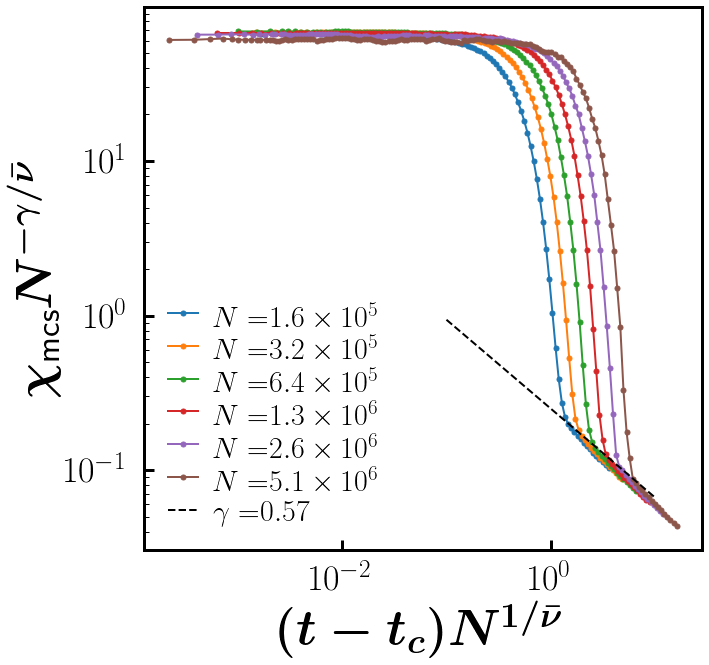

In [179]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, x, nu_bar = 0.936897, 0.25, 2.3
gamma = x * nu_bar
print("Gamma: " + str(gamma) + ", nu_bar:" + str(nu_bar))


def plot_mcs_scale(NList, scaled):
    for networkSize in NList:
        current = networkSize, acceptanceThreshold
        reduced_t = time[networkSize] - t_c
        reduced_t, mcs = reduced_t[reduced_t > 0] * networkSize, meanClusterSize[current][reduced_t > 0]
        reduced_t, mcs = avgLogBin(reduced_t[reduced_t < 2e-2 * networkSize], mcs[reduced_t < 2e-2 * networkSize], delta_exponent=0.03)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), mcs * np.power(networkSize, -x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, mcs, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        fit_x = np.array([0.1, 10])
        fit_y = np.power(fit_x, -gamma) * 0.25
        ax.plot(fit_x, fit_y, 'k--', label=latex_string("\\gamma=") + latex_float(gamma, 2), linewidth=2)
        ax.set_ylabel(latex_bold_string("\chi_\\text{mcs} N^{-\gamma/\\bar{\\nu}}"))
        ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
    else:
        ax.set_ylabel(latex_bold_string("\chi_\\text{mcs}"))
        ax.set_xlabel(latex_bold_string("t-t_c"))


NList = [160000, 320000, 640000, 1280000, 2560000, 5120000]
plot_mcs_scale(NList, True)


ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)

fig.show()


# Order Parameter Variance

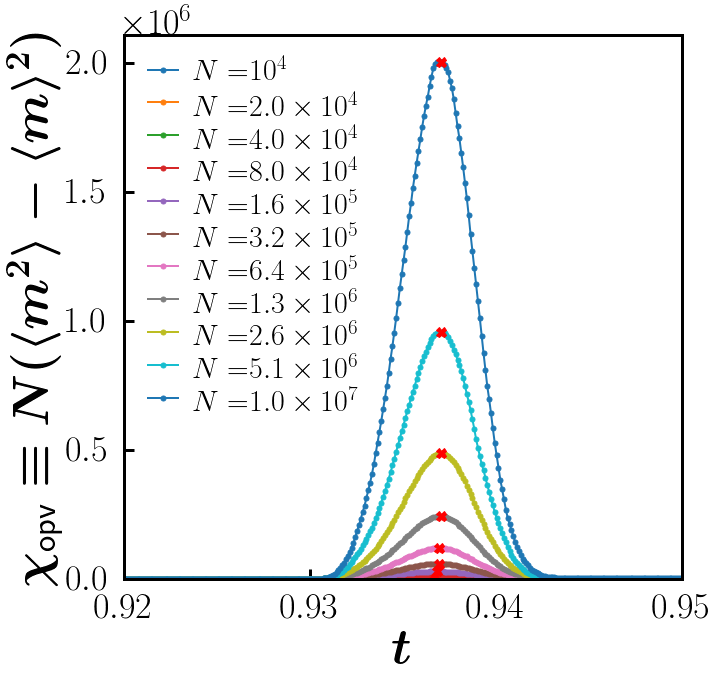

In [95]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotOPV(networkSize, plot_tc):
    current = networkSize, acceptanceThreshold
    t, opv = avgLinBin(time[networkSize], orderParameterVariance[current])
    ax.plot(t, opv, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2, markersize=5)
    t_var_c = points[current]["t_var_c"]
    ax.plot(t_var_c, orderParameterVariance[current][int(networkSize * t_var_c)], 'rX', markersize=10)
    if plot_tc:
        ax.plot([points[current]["t_c"],points[current]["t_c"]], [0, networkSize/10], 'g-', linewidth=2, label=latex_string("t_c({:.1e})".format(networkSize)))

for networkSize in networkSizeList:
    plotOPV(networkSize, False)

ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("\chi_\\text{opv} \equiv N(\langle m^2\\rangle - \langle m \\rangle ^2)"))
ax.set_xlim(chi_plotRange[acceptanceThreshold])
ax.set_ylim(bottom = 0)
ax.legend(loc="best", fontsize=30)

fig.show()


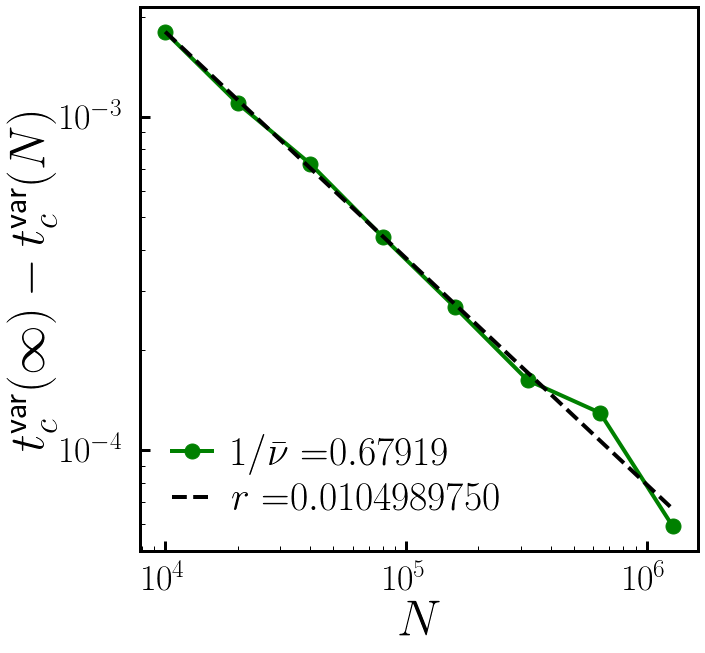

In [47]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_rasterized(True)

NList = [10000, 20000, 40000, 80000, 160000, 320000, 640000, 1280000]
y = []
for networkSize in NList:
    current = networkSize, acceptanceThreshold
    y.append(0.9371 - points[current]["t_var_c"])

fitX, fitY, nu, residual = logFit(NList, y)
ax.plot(NList, y, 'go-', label=latex_string("1/\\bar{\\nu}=") + latex_float(-1 * nu, 5))
ax.plot(fitX, fitY, 'k--', label=latex_string("r=") + latex_float(residual[0], 10))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(latex_string("N"))
ax.set_ylabel(latex_string("t_c^\\text{var}(\infty) - t_c^\\text{var}(N)"))
ax.legend(loc="lower left")

fig.show()

Gamma: 1.785, nu_bar:1.7


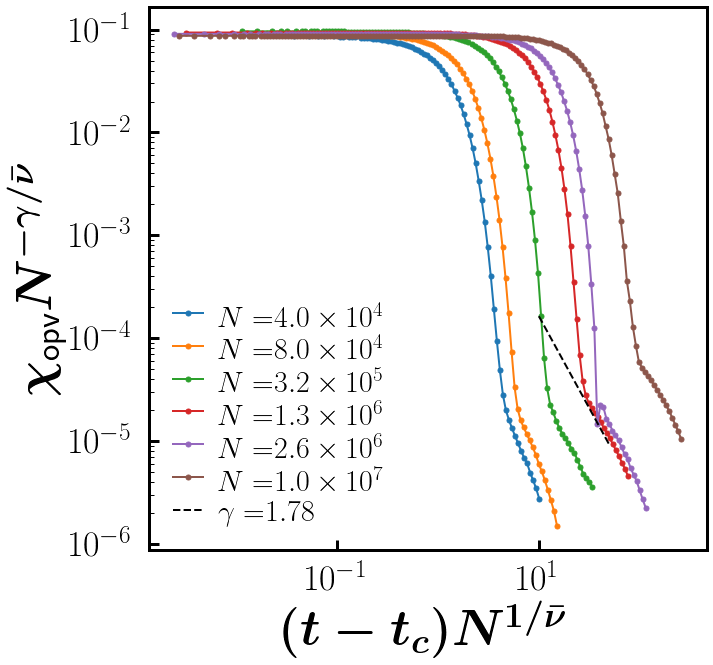

In [176]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, x, nu_bar = 0.9371, 1.05, 1.7
gamma = x * nu_bar
print("Gamma: " + str(gamma) + ", nu_bar:" + str(nu_bar))


def plot_opv_scale(NList, scaled):
    for networkSize in NList:
        current = networkSize, acceptanceThreshold
        reduced_t = time[networkSize] - t_c
        reduced_t, opv = reduced_t[reduced_t > 0] * networkSize, orderParameterVariance[current][reduced_t > 0]
        reduced_t, opv = avgLogBin(reduced_t[reduced_t < 2e-2 * networkSize], opv[reduced_t < 2e-2 * networkSize], delta_exponent=0.03)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), opv * np.power(networkSize, -x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, opv, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        fit_x = np.array([10, 50])
        fit_y = np.power(fit_x, -gamma) * 1e-2
        ax.plot(fit_x, fit_y, 'k--', label=latex_string("\\gamma=") + latex_float(gamma, 2), linewidth=2)
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv} N^{-\gamma/\\bar{\\nu}}"))
        ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
    else:
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv}"))
        ax.set_xlabel(latex_bold_string("t-t_c"))


NList = [40000, 80000, 320000, 1280000, 2560000, 10240000]
# NList = networkSizeList
plot_opv_scale(NList, True)


ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)

fig.show()


# Net order parameter variance

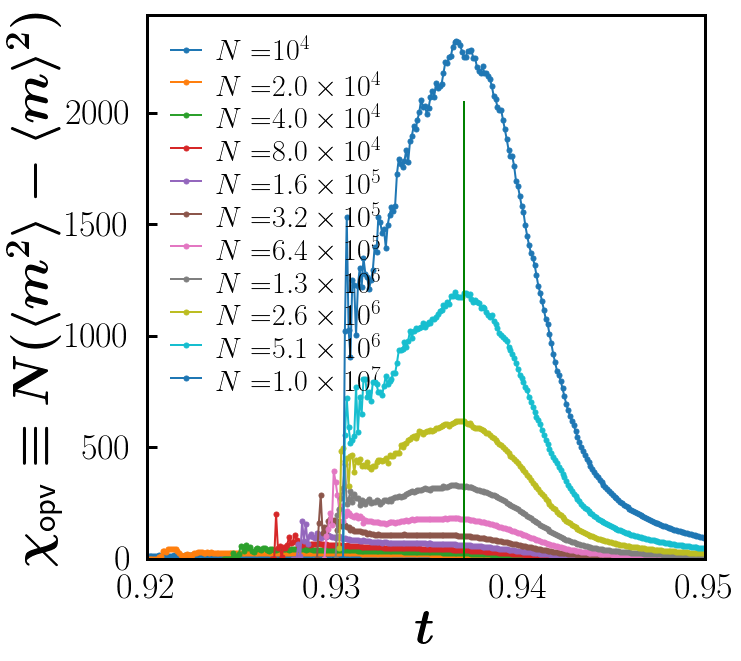

In [35]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotNetOPV(networkSize, plot_tc):
    current = networkSize, acceptanceThreshold
    t, net_opv = netOrderParameterVariance[current]["78super"]
    t, net_opv = avgLinBin(t/networkSize, net_opv)
    ax.plot(t, net_opv, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if plot_tc:
        ax.plot([points[current]["t_var_c"],points[current]["t_var_c"]], [0, networkSize/5000], 'g-', linewidth=2)

for networkSize in networkSizeList[:-1]:
    plotNetOPV(networkSize, False)
plotNetOPV(10240000, True)

ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("\chi_\\text{opv} \equiv N(\langle m^2\\rangle - \langle m \\rangle ^2)"))
ax.set_xlim(chi_plotRange[acceptanceThreshold])
ax.set_ylim(bottom = 0)
ax.legend(loc="best", fontsize=30)

fig.show()


Gamma: 2.175, nu_bar:2.9


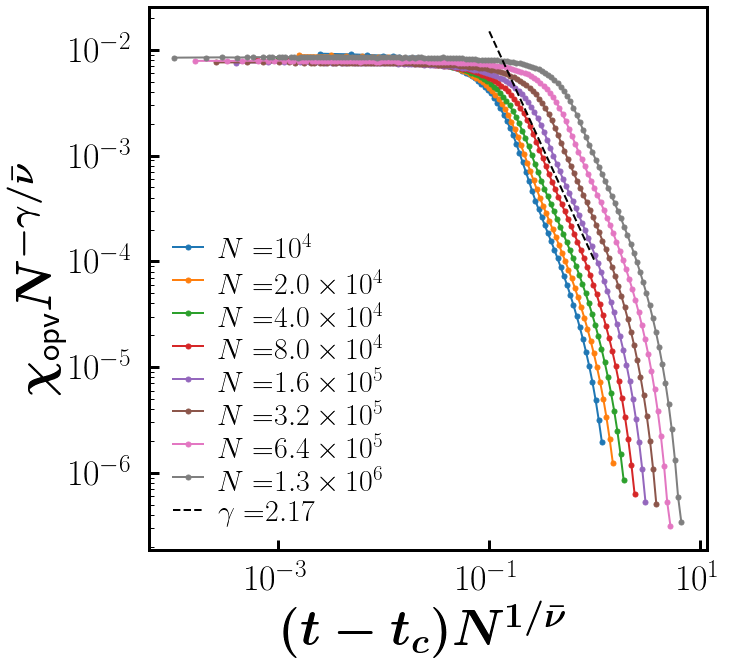

In [175]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

# t_c, x, nu_bar = 0.9371, 1.05, 1.7
t_c, x, nu_bar = 0.9371, 0.75, 2.9
gamma = x * nu_bar
print("Gamma: " + str(gamma) + ", nu_bar:" + str(nu_bar))


def plot_netopv_scale(NList, scaled):
    for networkSize in NList:
        current = networkSize, acceptanceThreshold
        t, net_opv = netOrderParameterVariance[current]["78super"]
        reduced_t = t - t_c * networkSize
        reduced_t, net_opv = reduced_t[reduced_t > 0], net_opv[reduced_t > 0]
        reduced_t, net_opv = avgLogBin(reduced_t[reduced_t < 5e-2 * networkSize], net_opv[reduced_t < 5e-2 * networkSize], delta_exponent=0.03)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), net_opv * np.power(networkSize, -x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, net_opv, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        fit_x = np.array([0.1, 1])
        fit_y = np.power(fit_x, -gamma) * 1e-4
        ax.plot(fit_x, fit_y, 'k--', label=latex_string("\\gamma=") + latex_float(gamma, 2), linewidth=2)
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv} N^{-\gamma/\\bar{\\nu}}"))
        ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
    else:
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv}"))
        ax.set_xlabel(latex_bold_string("t-t_c"))


NList = [10000, 20000, 40000, 80000, 160000, 320000, 640000, 1280000]
plot_netopv_scale(NList, scaled=True)


ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)

fig.show()


# Order Parameter

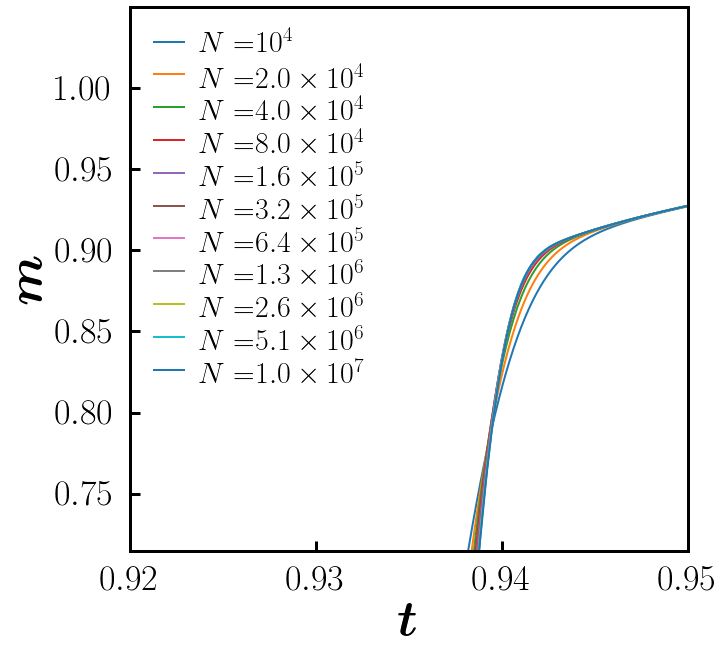

In [238]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotOP(networkSize):
    current = networkSize, acceptanceThreshold
    t, op = avgLinBin(time[networkSize], orderParameter[current])
    ax.plot(t, op, '-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2)
    # ax.plot(points[current]["t_c"], points[current]["m_c"], 'gX', markersize=10)

for networkSize in networkSizeList:
    plotOP(networkSize)

ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("m"))
ax.set_xlim(chi_plotRange[acceptanceThreshold])
ax.set_ylim(bottom = points[(10240000, 0.5)]["m_c"] * 7 / 8)
ax.legend(loc="best", fontsize=30)

fig.show()

beta: 0.204 nu_bar: 1.7
80000 0.009763676144205036
160000 0.00983696677379342
320000 0.009356697511486711
640000 0.00811443489879371
1280000 0.007762527114633322
2560000 0.006852098982422006
5120000 0.006615655183593638
10240000 0.006105775858593732


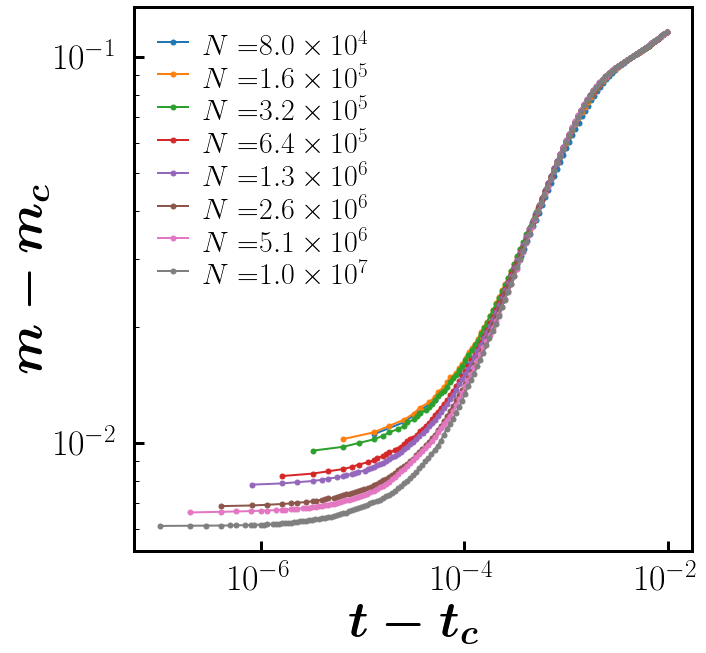

In [239]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, m_c, x, nu_bar = 0.9398, 0.810, 0.12, 1.7
beta = x * nu_bar
print("beta:", beta, "nu_bar:", nu_bar)

def plot_op_scale(NList, scaled):
    for networkSize in NList:
        current = networkSize, acceptanceThreshold
        reduced_t = time[networkSize] - t_c
        reduced_t, reduced_op = reduced_t[reduced_t>0] * networkSize, orderParameter[current][reduced_t > 0] - m_c
        print(networkSize, reduced_op[0])
        reduced_t, reduced_op = avgLogBin(reduced_t[reduced_t<1e-2*networkSize], reduced_op[reduced_t<1e-2*networkSize], delta_exponent=0.03)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), reduced_op * np.power(networkSize, x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, reduced_op, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        fit_x = np.array([1, 100])
        fit_y = np.power(fit_x, beta) * 0.3
        ax.plot(fit_x, fit_y, 'k--', label=latex_string("\\beta=") + latex_float(beta, 2), linewidth=2)
        ax.set_xlabel(latex_bold_string("(t-t_c) N^{1/\\bar{\\nu}}"))
        ax.set_ylabel(latex_bold_string("(m-m_c) N^{\\beta/\\bar{\\nu}}"))
    else:
        ax.set_xlabel(latex_bold_string("t-t_c"))
        ax.set_ylabel(latex_bold_string("m-m_c"))

NList = [80000, 160000, 320000, 640000, 1280000, 2560000, 5120000, 10240000]
# plot_op_scale(NList, scaled=True)
plot_op_scale(NList, scaled=False)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)
fig.show()


# Net Order Parameter

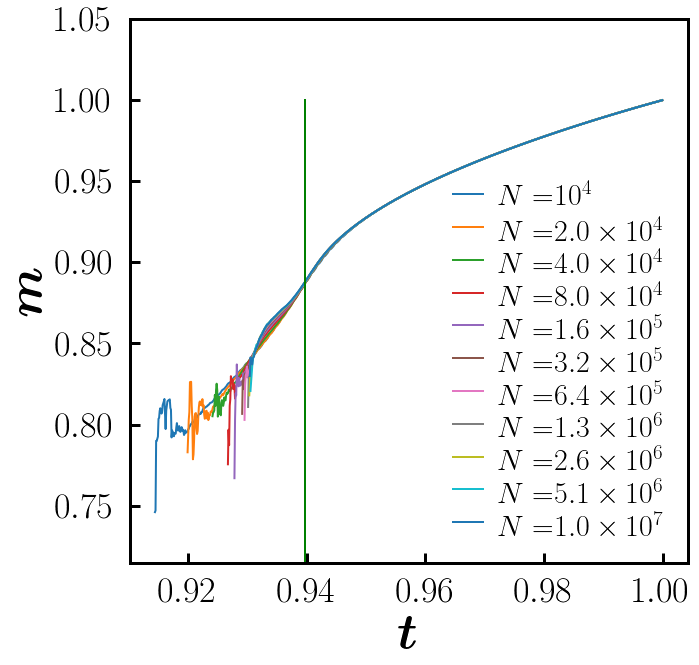

In [200]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotNetOP(networkSize):
    current = networkSize, acceptanceThreshold
    t, net_op = netOrderParameter[current]["78super"]
    t, net_op = avgLinBin(t/networkSize, net_op)
    ax.plot(t, net_op, '-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2)

for networkSize in networkSizeList:
    plotNetOP(networkSize)
# ax.plot([0.9, 1.0], [points[(10240000, 0.5)]["m_c"], points[(10240000, 0.5)]["m_c"]], 'g-', linewidth=2)
ax.plot([points[(10240000, 0.5)]["t_c"], points[(10240000, 0.5)]["t_c"]], [0,1], 'g-', linewidth=2)

ax.set_xlabel(latex_bold_string("t"))
ax.set_ylabel(latex_bold_string("m"))
ax.set_ylim(bottom = points[(10240000, 0.5)]["m_c"] * 7 / 8)
ax.legend(loc="best", fontsize=30)

fig.show()

beta: 0.17 nu_bar: 1.7
160000 0.002555458974138447
320000 0.0032060730032231755
640000 0.003665367489988136
1280000 0.0038386764003933704
2560000 0.003962065409958249
5120000 0.0042996819655279905
10240000 0.004380557685500386


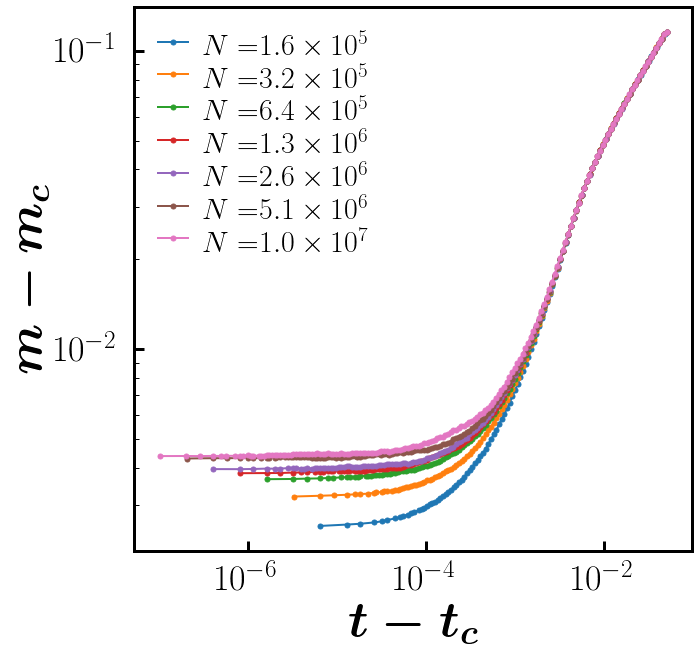

In [246]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

t_c, m_c, x, nu_bar = 0.9369, 0.87, 0.1, 1.7
# t_c, m_c, x, nu_bar = 0.9371, 0.44, 0.12, 1.7
beta = x * nu_bar
print("beta:", beta, "nu_bar:", nu_bar)

def plot_netop_scale(NList, scaled):
    for networkSize in NList:
        current = networkSize, acceptanceThreshold
        t, net_op = netOrderParameter[current]["78super"]
        reduced_t = t-t_c*networkSize
        reduced_t, reduced_op = reduced_t[reduced_t>0], net_op[reduced_t>0] - m_c
        print(networkSize, reduced_op[0])
        reduced_t, reduced_op = avgLogBin(reduced_t[reduced_t<5e-2*networkSize], reduced_op[reduced_t<5e-2*networkSize], delta_exponent=0.03)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1 / nu_bar), reduced_op * np.power(networkSize, x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, reduced_op, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        # fit_x = np.array([1, 100])
        # fit_y = np.power(fit_x, beta) * 0.3
        # ax.plot(fit_x, fit_y, 'k--', label=latex_string("\\beta=") + latex_float(beta, 2), linewidth=2)
        ax.set_xlabel(latex_bold_string("(t-t_c) N^{1/\\bar{\\nu}}"))
        ax.set_ylabel(latex_bold_string("(m-m_c) N^{\\beta/\\bar{\\nu}}"))
    else:
        ax.set_xlabel(latex_bold_string("t-t_c"))
        ax.set_ylabel(latex_bold_string("m-m_c"))

NList = [160000, 320000, 640000, 1280000, 2560000, 5120000, 10240000]
# NList = networkSizeList
plot_netop_scale(NList, scaled=False)
# plot_netop_scale(NList, scaled=True)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc="best", fontsize=30)
fig.show()
